In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'#'svg' would be better, but eats memory for these big plots.
from matplotlib import pyplot as plt
import numpy as np
import GPy
import sys
import os
import pandas as pd
import GPclust
import math
os.chdir('/home/mazin/skoltech/projects/evo.devo')

In [10]:
psi = pd.read_csv('output/hmo.brain.sign.psis.tab', delimiter="\t", header=0, index_col=0)

#times = np.matrix([[float(i)] for i in psi.columns.values.tolist()])
times = np.array(range(1,11)).reshape(10,1)
sids = psi.index.values
psi = psi.as_matrix()


print(sids[1:10])
print(times.shape)
print(times.T)
print(psi.shape)

['hum_002414.s15' 'hum_002462.s3' 'hum_002466.s6' 'hum_002470.s11'
 'hum_002497.s9' 'hum_002497.s21' 'hum_002528.s9' 'hum_002575.s10'
 'hum_002625.s9']
(10, 1)
[[ 1  2  3  4  5  6  7  8  9 10]]
(5583, 10)


[ 0.30290029  0.89072062]
[[ 0.06148311  0.01781515  0.16869323  0.46550062  0.52151463  0.577551
   0.5896263   0.21879671  0.2575893   0.15043282]
 [ 0.95710095  0.96761441  0.94704325  0.9490491          nan  0.9258217
   0.95842366  0.89761314  0.74921814  0.66460124]]


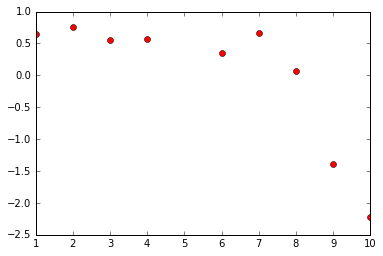

In [11]:
psi -= np.array([np.nanmean(x) for x in psi])[:,np.newaxis]
psi /= np.array([np.nanstd(x) for x in psi])[:,np.newaxis]
plt.plot(times,psi[1,:] , 'ro')

In [107]:
k_underlying = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=7.)
k1=GPy.kern.Matern52(input_dim=1, variance=0.1, lengthscale=7.)
k2=GPy.kern.White(1, variance=0.3)
#avoid under-estimating (non-structured noise)
k2.variance.fix(0.7)
k_corruption = k1+ k2
print(times)

[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]


In [108]:
m = GPclust.MOHGP(times, k_underlying, k_corruption, psi, K=20, prior_Z='DP', alpha=1e-6)

In [109]:
m.hyperparam_opt_interval = 100 # how often to optimize the hyperparameters
m.hyperparam_opt_args['messages'] = True # turn off the printing of the optimization
m.optimize()
m.systematic_splits(verbose=True)

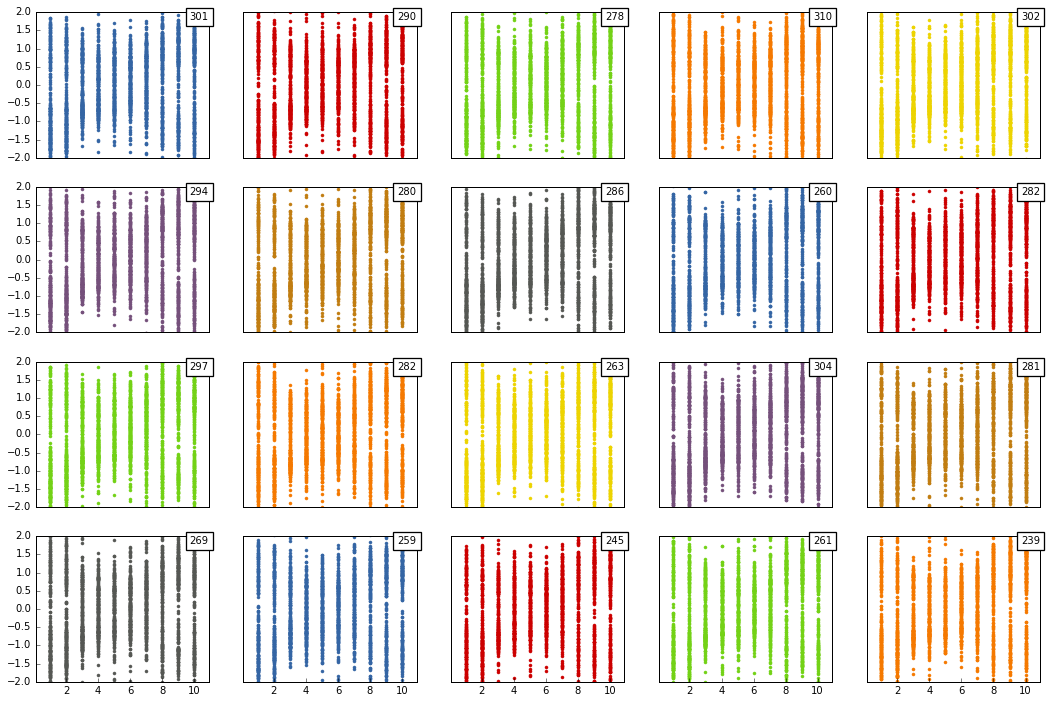

In [110]:
m.reorder()# plot the biggest clusters at the top
plt.figure(figsize=(18,12))
m.plot(on_subplots=True, colour=True, in_a_row=False, newfig=False, min_in_cluster=1, joined=False, ylim=(-2,2), data_in_replicate=False)

#plt.savefig(outdir+"/Clusters"+nameAnalysis+'.png')

In [111]:
print(m)


Name : MOHGP
Objective : nan
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  MOHGP.                 |  value  |  constraints  |  priors
  Mat52.variance         |    1.0  |      +ve      |        
  Mat52.lengthscale      |    7.0  |      +ve      |        
  sum.Mat52.variance     |    0.1  |      +ve      |        
  sum.Mat52.lengthscale  |    7.0  |      +ve      |        
  sum.white.variance     |    0.7  |   fixed +ve   |        


In [112]:
m.phi.shape
noClusters=m.phi.shape[1]
noGenes=m.phi.shape[0]
print(psi.shape)
print(m.phi.shape)
np.savetxt("output/hmo.brain.sign.psis.GPClust.out.tab", m.phi, delimiter="\t")

(5583, 10)
(5583, 20)
